In [4]:
import numpy as np
import os
from tqdm.notebook import tqdm
import h5py
from datetime import datetime

import matplotlib.pyplot as plt
from pde import MemoryStorage, PDEBase, FieldCollection, ScalarField, VectorField, MemoryStorage, CartesianGrid
from pde import solve_laplace_equation, solve_poisson_equation

from plotting import plot_fracture_prob, plot_press, plot_sat

CURR_DIR = os.getcwd()


In [13]:
class Two_Phase_Vanilla(PDEBase):
  
    def __init__(self):
        super().__init__()
        self.eps = 1e-3  # just 0.001
        self.shape = (40, 100, 2) # points
        self.sides = ((0, 4), (0, 10), (0, 1)) # meters
        
        self.O = (2, 2, 0.5) # центр области с газогидратом, метры
        self.R0 = 1 # радиус области разложения газогидрата, метры

        self.t_scale = 3600 # sec - масштаб времени

        # параметры среды
        self.k = 0.01 # Darcy проницаемсть
        self.m = 0.5 # поистость

        # параметры флюидов
        self.ro_gas = 1.28 # начальная плотность газа kg/m3
        self.ro_liq = 1000 # плотность жидкоти kg/m3

        self.nu_gas = 0.01 / self.t_scale # вязкость газа cP
        self.nu_liq = 1 / self.t_scale # вязкость жидкости cP

        # начальная насыщенность
        self.s0 = 0 # во всей области
        self.s0_gas = 0.2 # начальная насыщенность в области с газом
      
        # пороговый градиент
        self.G = 0.01 # МПа/м  - равен гидростатики например

        # распределённый источник газа 
        self.q = 1e-6 * self.t_scale # это dro/dt, если выделение газа 1 кг в куб. метре в секунду, то q=1 кг/м3*сек

        # generate grid
        self.grid = CartesianGrid(self.sides, self.shape)  

        # выделенная область с газом
        xyz = self.grid.cell_coords # координаты сетки
        xh, yh, zh = np.where(self.grid.distance(xyz, self.O) <= self.R0) # координаты области с газогидратом

        # поле проницаемости со случайными вариациями 
        rand_k = np.ones(self.shape) * self.k 
        rand_k[:,3:-3,:]  = rand_k[:,3:-3,:] + 0.2 * np.random.randn(*(rand_k[:,3:-3,:].shape)) * self.k 
        self.k_field = ScalarField(self.grid, data=rand_k)

        # g field  - поле силы тяжести
        g = np.zeros((3,) + self.shape) # 
        g[1,:] = - 9.81 * 1e-6 # gravity by Y ax; 1e-6 - to be good with pressire in MPa
        self.g_field = VectorField(self.grid, data=g) # grav field

        # s initial field - начальное поле насыщенности газом
        s_ini = np.ones(self.shape) * self.s0 # насыщенность во всём объёме
        s_ini[xh, yh, zh] = self.s0_gas # насыщенность в области с газом 
        self.s_ini_field = ScalarField(self.grid, data=s_ini) 

        # source field - распределённый источник газа. q по сути это dro/dt в области выделения, если выделение газа 1 кг в куб. метре в секунду, то q=1 кг/м3*сек
        q = np.zeros(self.shape)
        q[xh, yh, zh] = self.q 
        self.source_field = ScalarField(self.grid, data=q) 

        # boundary condition       
        # hydrostatic field - гидростатическое поле давления
        self.ro_g_h = self.get_ro_g_h(self.ro_liq)
        P_up = self.ro_g_h[:,-1,:]
        P_down = self.ro_g_h[:,0,:]
        self.p_bc = [{'derivative': 0}, [{'value':P_down}, {'value':P_up}], {'derivative': 0}] # граничное условие на давление (непроницаемые границы, сверху сток)
        self.s_bc = {'derivative': 0} # граничные условия на S 

    # метод для вычисления гидростатического давления, плотность должна быть в кг/м3
    def get_ro_g_h(self, ro):
        ro_g = self.g_field.to_scalar().data * ro * self.grid.cell_volume_data[1] 
        ro_g_h = np.cumsum(ro_g, axis=1) - ro_g/2 # гидростатическое давление, среднее по ячейке, поэтому минус половина ro_g
        ro_g_h = np.flip(ro_g_h, axis=1) # Y направлена снизу вверх
        return ro_g_h

    # относительные фазовые проницаемости: 
    # для газа
    def k_s_gas(self, s):
        return s
    
    # для жидкости
    def k_s_liq(self, s):
        return 1 - s # s - насыщенность газа!!!
    
    def f(self, s):
        fs = s/(s + (self.nu_gas/self.nu_liq) * (1-s))
        return fs
    
    def df_ds(self, s):
        dfs_ds = (self.nu_gas/self.nu_liq)/((s + (self.nu_gas/self.nu_liq) * (1-s))**2)
        return dfs_ds
        
    # обобщённый закон Дарси для Газа
    def darcy_gas(self, grad_P, ro, nu, s):
        a = 1e-3 * self.k_field * self.k_s_gas(s) / nu #  const, [k] = [D], [nu] = cP => 1e-3 to be good with pressure gradient in MPa/m
        g = self.g_field
        w = - a * (grad_P - ro * g) # Darcy law
        return w
    
    # обобщённый закон Дарси для Жидкости
    def darcy_liq(self, grad_P, ro, nu, s):
        "s - это насыщенность газа!"
        a = 1e-3 * self.k_field * self.k_s_liq(s) / nu #  const, [k] = [D], [nu] = cP => 1e-3 to be good with pressure gradient in MPa/m
        g = self.g_field
        w = - a * (grad_P - ro * g) # Darcy law
        return w
      
    # обобщённый закон Дарси для жидкости с пороговым градиентом G (пока постоянным)
    def darcy_liq_TPG(self, grad_P, ro, nu, s):
        "s - это насыщенность газа!"
        a = 1e-3 * self.k_field * self.k_s_liq(s) / nu #  const, [k] = [D], [nu] = cP => 1e-3 to be good with pressure gradient in MPa/m
        g = self.g_field
        grad = grad_P - ro * g # обычный градиент
        gd = grad.to_scalar().data # модуль вектора обычного градиента
        Gd = np.ones_like(gd) * self.G # модуль G
        k_tpg = np.max((1 - Gd/gd, np.zeros_like(gd)), axis=0) # ноль если градиент меньше G, градиент минус G, если больше
        w = - a * k_tpg * grad  # TPG + Darcy law
        return w 

    # делаем насыщенность от eps до 1-eps 
    def check_s(self, s):
        sd = s.data
        eps = np.ones_like(sd) * self.eps
        new_s = np.max((sd, eps), axis=0)
        new_s = np.min((new_s, 1-eps), axis=0)
        return ScalarField(self.grid, data=new_s)
    
    # делаем, чтобы изменение насыщенности было в рамках [eps, 1-eps] 
    def check_ds_dt(self, s, ds_dt):
        sd = s.data
        ds_dtd = ds_dt.data
        eps = np.ones_like(sd) * self.eps
        new_ds_dt = np.zeros_like(sd)
        valid_ds_dt = (sd + ds_dtd > eps) & (sd + ds_dtd < 1 - eps)
        new_ds_dt[valid_ds_dt] = ds_dtd[valid_ds_dt]
        return ScalarField(self.grid, data=new_ds_dt)
    
    # метод для решения уравнения Пуассона для давления
    def solve_P_eq(self, s):
        s = self.check_s(s)
        q = self.source_field
        rhs = - (q/self.ro_gas) * self.nu_gas * self.f(s)/self.k_s_gas(s)
        P = solve_poisson_equation(rhs, self.p_bc)
        return P
     

    # вся магия тут
    def evolution_rate(self, state, t=0):
        ''' Basniev pp.256'''
        s = state 
        s = self.check_s(s)

        P = self.solve_P_eq(s)

        grad_P = P.gradient(self.p_bc) # он одинаковый для обеих фаз, так ка давления отличаются на константу

        w1 = self.darcy_gas(grad_P, 0, self.nu_gas, s) # скорость фильтрации газа. 
        # тут плотность ноль, чтобы пренебречь гидростатикой, так как она много меньше по сравнению с гидростатикой жидкости 

        w2 = self.darcy_liq(grad_P, self.ro_liq, self.nu_liq, s) # скорость фильтрации жидкости по дарси, либо 
        # w2 = self.darcy_liq_TPG( grad_P_liq,  self.ro_liq, self.nu_liq, s) # по Дарси с пороговым градиентом

        q = self.source_field # поле источника газа
        ds_dt = - (1/self.m) * self.df_ds(s)*((w1 + w2) @ s.gradient(self.s_bc)) + (q/self.ro_gas) * (1 - self.f(s))

        ds_dt = self.check_ds_dt(s, ds_dt) # на всякий случай обрезаем изменение насыщенности, чтобы она не выходила за границы разумного
 
        return ds_dt

In [20]:
eq = Two_Phase_Vanilla()

ini_state = eq.s_ini_field
storage = MemoryStorage()
# t_tange относительно self.t_scale - масштаба времени
res = eq.solve(ini_state, t_range=100, dt=1, tracker=['progress', 'plot', storage.tracker(1)])

sat = np.array(storage.data)
press = np.array([eq.solve_P_eq(s).data for s in tqdm(storage)]) # это работает почти столько же, сколько считается само уравнеие, не придумал пока, как на лету это сохранять

yield_path = f'{CURR_DIR}/{'sat_and_press'}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5'

with h5py.File(yield_path, 'w') as targ:
    perm_h5_set = targ.create_dataset("press",  data=press) 
    dens_h5_set = targ.create_dataset("s",  data=sat)   

  0%|          | 0/100.0 [00:00<?, ?it/s]

Output()

  0%|          | 0/101 [00:00<?, ?it/s]

In [21]:
from scipy.special import expit

eq = Two_Phase_Vanilla()

'''
Считаем возможность возникновение выброса
'''

with h5py.File(yield_path, 'r') as f:
    press = f['press'][:]
    s = f['s'][:]

ro_solid = 2700 # kg/m3 плотность песка
P0 = 0.1 # началльное давление в воде (гидростатика, прибавляем давление столба воды сверху дна)
Pc = 0.06 # rfgbkkzhyjt

liq_ro_g_h =  press + P0 
gas_ro_g_h = liq_ro_g_h + Pc
solid_ro_g_h = eq.get_ro_g_h(ro_solid) + P0 # литостатика

'''
Критерий выброса - превышение порового давления над литостатикой.
Поровое давление предлагаю считать среднее между газом и жидкостью с весом насыщенностию
Ну то есть если есьт некий объём среды, часть которого занята газом, а часть жидкостью, 
то на скелет действует давление газа там где газ, и жидкости там, где жидкость, пропорционально их долям, а это иесть насыщенность.
Как на самом деле надо считать - мне не очень непонятно. В реальности вода смачивает скелет, то есть он контактирует только с водой. 
Но в концепции фазовых проницаемостей мы считаем, что флюиды каждый по отдельности взаимодействуют только со скелетом, а не между собой, 
поэтому мы можем применять дари для каждой из фаз.
Вобщем тут вопрос философский. 
'''
sigma = 0.02 # сигма разницы порового и литостатики, при которых начнётся разрушение, 
pore_press = s * gas_ro_g_h + (1-s) * liq_ro_g_h # средневзвешенное поровое давление

# вероятность возникновения разрушения
fracture_prob = expit((pore_press/solid_ro_g_h - 1)/sigma) # логистичекая сигмоида от отношения порового и литостатики, чтобы вероятность на графике была красивее
'''
expit(x) = 1/(1+exp(-x))
expit(0) = 0.5
expit(3) = 0.95
то естсь при отношении порового и литостатики, равного 1 вероятность 0.5, а при разнице плюс мину 3 сигма вероятность будет от 0.05 до 0.95 примерно:

Пример для понимания - 
sigma = 0.02
x = np.linspace(0,2,100)
fr_prob = expit((x-1)/(sigma))

fig, ax = plt.subplots()
ax.plot(x, fr_prob )
'''
pass

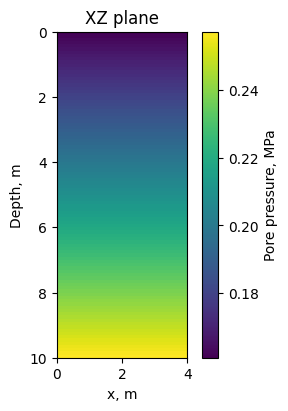

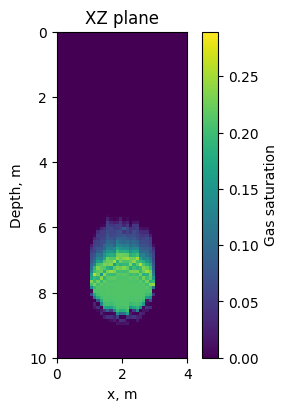

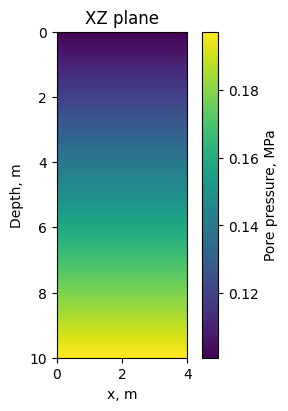

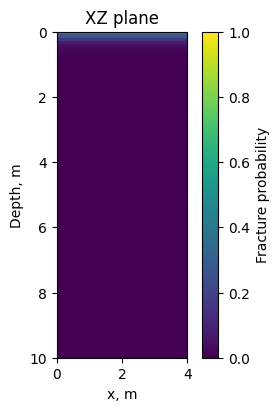

In [22]:
plot_press(eq, gas_ro_g_h[-1])
plot_sat(eq, s[-1])
plot_press(eq, liq_ro_g_h[-1])
plot_fracture_prob(eq, fracture_prob[-1])